Old feature engineering was for RF model. Trying again with XGB

In [1]:
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler

c:\Users\joshc\anaconda3\envs\pytorch\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Define Paths
train_csv_path = "C:/Users/joshc/OneDrive/Documents/01 Trying too hard/Machine Learning and AI/Kaggle/titanic/Datasets/train.csv"
final_test_csv_path = "C:/Users/joshc/OneDrive/Documents/01 Trying too hard/Machine Learning and AI/Kaggle/titanic/Datasets/test.csv"


In [3]:
base_df = pd.read_csv(train_csv_path)
base_df.info()
base_df.corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


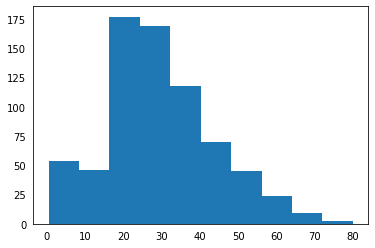

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(base_df["Age"])
ax.tick_params(axis="both", color="white")

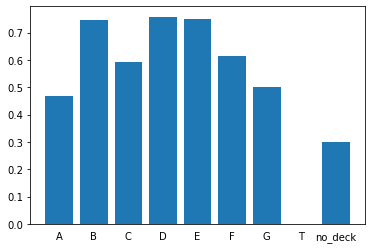

In [5]:
# Cabin exploration
def get_deck(cabin):
    if cabin == cabin:
        return cabin[:1]
    else:
        return "no_deck"

deck = pd.DataFrame(base_df["Cabin"].apply(get_deck))
deck.rename(columns={"Cabin": "Deck"}, inplace=True)
train_df = pd.concat([base_df, deck], axis=1)[["Survived", "Deck"]]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(train_df.groupby("Deck").mean().index, train_df.groupby("Deck").mean()["Survived"])
ax.tick_params(axis="x", color="white")

In [35]:
def prep_data(in_df):
    out_df = in_df.copy()
    
    # Fill NA for age with mode
    age_mode = out_df["Age"].mode()[0]
    out_df["Age"] = out_df["Age"].fillna(age_mode)
    out_df["child"] = (out_df["Age"] <= 15).astype(int)

    # Get dummies for sex
    gender_dummies = pd.get_dummies(out_df["Sex"]).astype(int)
    out_df = pd.concat([out_df, gender_dummies], axis=1)

    # Get dummies for embarkation port
    port_dummies = pd.get_dummies(out_df["Embarked"]).astype(int)
    out_df = pd.concat([out_df, port_dummies], axis=1)

    # Get title from name, then get dummies
    def get_title(name):
        title = re.sub(", ", "", re.search(", \w+", name).group(0))
        if title not in ["Mr", "Miss", "Mrs", "Master"]:
            title = "other"
        return title

    out_df["title"] = out_df["Name"].apply(get_title)
    title_dummies = pd.get_dummies(out_df["title"]).astype(int)
    out_df = pd.concat([out_df, title_dummies], axis=1)

    # Get deck from Cabin, then get dummies
    def get_deck(cabin):
        if cabin == cabin:
            return cabin[:1]
        else:
            return "no_deck"
        
    deck = pd.DataFrame(in_df["Cabin"].apply(get_deck))
    deck_dummies = pd.get_dummies(deck).astype(int)
    out_df = pd.concat([out_df, deck_dummies], axis=1)

    # Drop non-numerical
    out_df = out_df.select_dtypes(exclude="object")
    columns_to_drop = ["PassengerId", "SibSp", "Parch", "Q", "male", "Cabin_T", 
                       "Cabin_G", "other", "Cabin_A", "Cabin_F", "Age", "S", 
                       "Master", "Cabin_C", "Cabin_E", "Cabin_B", "Cabin_D", "C"]
    columns_to_drop = [col for col in columns_to_drop if col in out_df.columns]
    out_df.drop(columns=columns_to_drop, inplace=True)
    
    return out_df

In [36]:
train_df = prep_data(base_df)
train_df.corr()["Survived"].sort_values()

Mr              -0.549199
Pclass          -0.338481
Cabin_no_deck   -0.316912
child            0.136107
Fare             0.257307
Miss             0.327093
Mrs              0.339040
female           0.543351
Survived         1.000000
Name: Survived, dtype: float64

In [37]:
X = train_df.drop(columns="Survived")
y = train_df["Survived"]

# Feature scaling
columns = X.columns

std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X.to_numpy())
X_scaled = pd.DataFrame(X_scaled, columns=columns)

In [38]:
# Evaluate default XGBClassifier()

# Define model
model = XGBClassifier()

# Fit model
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)
n_scores = cross_val_score(model, X_scaled, y, scoring='accuracy', cv=rskf, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.831 (0.037)


In [30]:
# Basic hyperparameter tuning
models = []
n_scores = []

max_depth_values = range(1,10)
n_estimators = [10, 50, 100, 500]

for depth in max_depth_values:
    for n in n_estimators:
        xgb_model = XGBClassifier(max_depth=depth, n_estimators=n)
        models.append(xgb_model)

for model in models:
    mean_score = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=rskf, n_jobs=-1))
    n_scores.append({
        "mean_score": mean_score,
        "max_depth": model.max_depth,
        "n_estimators": model.n_estimators
        })
    print(f"Finished model: max_depth = {model.max_depth}, n_estimators = {model.n_estimators} --> mean_score = {mean_score:.3f}")

results_df = pd.DataFrame(n_scores, columns=n_scores[0].keys())   
results_df.sort_values("mean_score", ascending=False)

Finished model: max_depth = 1, n_estimators = 10 --> mean_score = 0.787
Finished model: max_depth = 1, n_estimators = 50 --> mean_score = 0.790
Finished model: max_depth = 1, n_estimators = 100 --> mean_score = 0.795
Finished model: max_depth = 1, n_estimators = 500 --> mean_score = 0.802
Finished model: max_depth = 2, n_estimators = 10 --> mean_score = 0.802
Finished model: max_depth = 2, n_estimators = 50 --> mean_score = 0.820
Finished model: max_depth = 2, n_estimators = 100 --> mean_score = 0.823
Finished model: max_depth = 2, n_estimators = 500 --> mean_score = 0.825
Finished model: max_depth = 3, n_estimators = 10 --> mean_score = 0.817
Finished model: max_depth = 3, n_estimators = 50 --> mean_score = 0.829
Finished model: max_depth = 3, n_estimators = 100 --> mean_score = 0.823
Finished model: max_depth = 3, n_estimators = 500 --> mean_score = 0.817
Finished model: max_depth = 4, n_estimators = 10 --> mean_score = 0.827
Finished model: max_depth = 4, n_estimators = 50 --> mean_

,mean_score,max_depth,n_estimators
29,0.833117,8,50
16,0.831257,5,10
33,0.831240,9,50
14,0.829746,4,100
20,0.829392,6,10
25,0.828997,7,50
32,0.828656,9,10
24,0.828656,7,10
28,0.828635,8,10
9,0.828618,3,50


In [31]:
# Basic hyperparameter tuning
models = []
n_scores = []

max_depth_values = [6]
n_estimators = [50, 75, 100, 125, 150]
learning_rates = [0.4, 0.3, 0.2, 0.1]

for depth in max_depth_values:
    for n in n_estimators:
        for learning_rate in learning_rates:
            xgb_model = XGBClassifier(max_depth=depth, n_estimators=n, learning_rate=learning_rate)
            models.append(xgb_model)

for model in models:
    mean_score = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=rskf, n_jobs=-1))
    n_scores.append({
        "mean_score": mean_score,
        "max_depth": model.max_depth,
        "n_estimators": model.n_estimators,
        "learning_rate": model.learning_rate
        })
    print(f"Finished model: learning_rate = {model.learning_rate:.4f}, n_estimators = {model.n_estimators} --> mean_score = {mean_score:.3f}")

results_df = pd.DataFrame(n_scores, columns=n_scores[0].keys())
results_df.sort_values("mean_score", ascending=False)

Finished model: learning_rate = 0.4000, n_estimators = 50 --> mean_score = 0.828
Finished model: learning_rate = 0.3000, n_estimators = 50 --> mean_score = 0.829
Finished model: learning_rate = 0.2000, n_estimators = 50 --> mean_score = 0.829
Finished model: learning_rate = 0.1000, n_estimators = 50 --> mean_score = 0.830
Finished model: learning_rate = 0.4000, n_estimators = 75 --> mean_score = 0.828
Finished model: learning_rate = 0.3000, n_estimators = 75 --> mean_score = 0.826
Finished model: learning_rate = 0.2000, n_estimators = 75 --> mean_score = 0.831
Finished model: learning_rate = 0.1000, n_estimators = 75 --> mean_score = 0.832
Finished model: learning_rate = 0.4000, n_estimators = 100 --> mean_score = 0.825
Finished model: learning_rate = 0.3000, n_estimators = 100 --> mean_score = 0.825
Finished model: learning_rate = 0.2000, n_estimators = 100 --> mean_score = 0.829
Finished model: learning_rate = 0.1000, n_estimators = 100 --> mean_score = 0.830
Finished model: learning

,mean_score,max_depth,n_estimators,learning_rate
15,0.831989,6,125,0.1
19,0.831623,6,150,0.1
7,0.831623,6,75,0.1
6,0.830870,6,75,0.2
3,0.830141,6,50,0.1
11,0.830121,6,100,0.1
2,0.828631,6,50,0.2
10,0.828627,6,100,0.2
1,0.828618,6,50,0.3
4,0.827882,6,75,0.4


In [39]:
final_model = XGBClassifier(max_depth=6, n_estimators=125, learning_rate=0.1)
final_model.fit(X, y)
n_scores = cross_val_score(final_model, X_scaled, y, scoring='accuracy', cv=rskf, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

c:\Users\joshc\anaconda3\envs\pytorch\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\joshc\anaconda3\envs\pytorch\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:09:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.834 (0.037)


In [40]:
test_data_df = pd.read_csv(final_test_csv_path)
X_test = prep_data(test_data_df)

In [41]:
y_pred = final_model.predict(X_test)

y_pred_df = pd.DataFrame()
y_pred_df["PassengerId"] = test_data_df["PassengerId"]
y_pred_df["Survived"] = y_pred

y_pred_df.to_csv("Datasets/submission 10.csv", index=False)